# Description

We already have prepared data for applying a clustering algorithm. We are going to use one of the most common algorithms — KMeans, because it needs only one parameter — the number of clusters (for example, DBSCAN needs two parameters) and works pretty well with large data (for example, agglomerative clustering is slow with large data).

# Import libraries

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import umap
import joblib

plt.style.use('ggplot')
plt.close('all')

In [2]:
# This is done to avoid seeing warnings in Jupyter Notebook

import warnings
warnings.filterwarnings('ignore')

# Load the preprocessed data

In [3]:
df = pd.read_csv('../data/preprocessed_data.csv')

In [5]:
# check the data

df.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,title
0,-0.881528,0.435086,-0.002348,0.138545,-0.309979,0.291043,0.780108,-0.089343,-0.051965,-0.122346,...,0.011067,0.135440,0.009302,-0.135259,-0.036759,0.005865,0.067443,-0.064825,-0.041612,Toy Story
1,-0.457887,-0.246543,-0.383760,0.678759,0.137287,0.531431,1.132837,0.027701,-0.023152,-0.259651,...,0.008981,0.044314,0.001732,-0.058217,-0.010985,-0.039142,0.024793,-0.002603,-0.003757,Jumanji
2,-0.638993,0.768074,0.256022,-0.220891,0.599786,-0.242320,-0.001552,0.013555,-0.030947,-0.016190,...,0.012393,0.112254,0.004677,-0.051300,0.010108,0.065319,0.077499,0.025520,0.008961,Grumpier Old Men
3,0.204259,1.059727,0.399481,-0.159060,0.403462,-0.023763,-0.074642,-0.039762,-0.046848,0.019834,...,-0.022144,-0.005580,0.004474,-0.005043,0.009631,-0.029076,-0.005324,0.011358,-0.003998,Waiting to Exhale
4,-0.740343,0.416806,0.105290,-0.133184,-0.273028,-0.025288,-0.077700,-0.073439,-0.026090,0.005135,...,0.064017,0.088048,-0.011469,-0.040830,-0.090784,0.002157,0.020374,-0.035388,0.074111,Father of the Bride Part II


In [7]:
# leave numeric columns for training model

X = df.drop(columns=['title'])

# Getting of optimal number of clusters

We are going to use KMeans, so we need to find the optimal k — the number of clusters. We are going to use two basic methods: the elbow method and the silhouette score.

In [8]:
num_clusters = np.arange( 1, 101, 1 )

inertias = []
silhouette_scores = []

for cluster in num_clusters:

    kmeans = KMeans(n_clusters=cluster)
    labels = kmeans.fit_predict(X)

    inertias.append( kmeans.inertia_ )


    if cluster > 1:

        # create data sampling for compute silhouette score 

        sample_idx = np.random.choice(X.shape[0], size=10000, replace=False) 
        X_sample = X.iloc[ sample_idx, : ]
        labels_sample = labels[ sample_idx ]

        silhouette_scores.append( silhouette_score( X_sample, labels_sample ) )


So we have computed inertia and silhouette score for n_clusters = 1 ... 100 (for silhouette score, we start from 2 clusters). We have computed the silhouette score not for the whole dataset but for a sample of size 10,000, because for the entire dataset it would take much longer

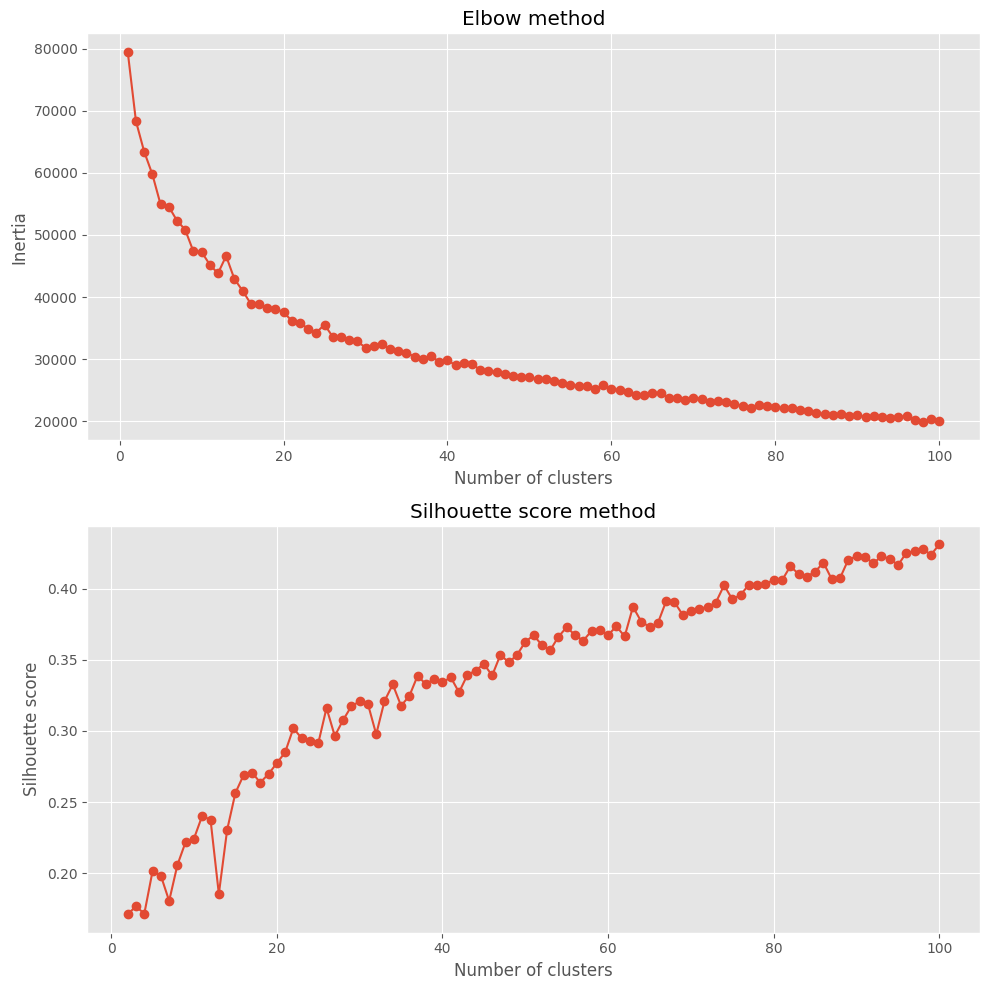

In [9]:
# visualize results

plt.figure( figsize=(10, 10) )

plt.subplot(2, 1, 1)
plt.plot( num_clusters, inertias, marker='o' )
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(2, 1, 2)
plt.plot( num_clusters[1:], silhouette_scores, marker='o' )
plt.title('Silhouette score method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

plt.tight_layout()
plt.show()

We see that the silhouette score method doesn't give a good result, because based on the graph, the optimal k is the largest number we tested — 100. It is unlikely to be beneficial in our case (creating a recommendation system) to divide films into 100 clusters or more. However, if we look at the elbow method graph, we can identify a break at 30–35 clusters, after which inertia nearly doesn't decrease. This is good news because in the film industry, there are approximately 30–40 types of films. It means the algorithm understood the structure of the data well.

# Training model

Based on the elbow method, we are going to use k = 30.

In [10]:
# train model

model = KMeans(n_clusters=30)
model.fit(X)

KMeans(n_clusters=30)

In [14]:
# get labels

df['cluster'] = model.labels_

In [15]:
# get centers of clusters

centers = model.cluster_centers_

# Number of films in each cluster

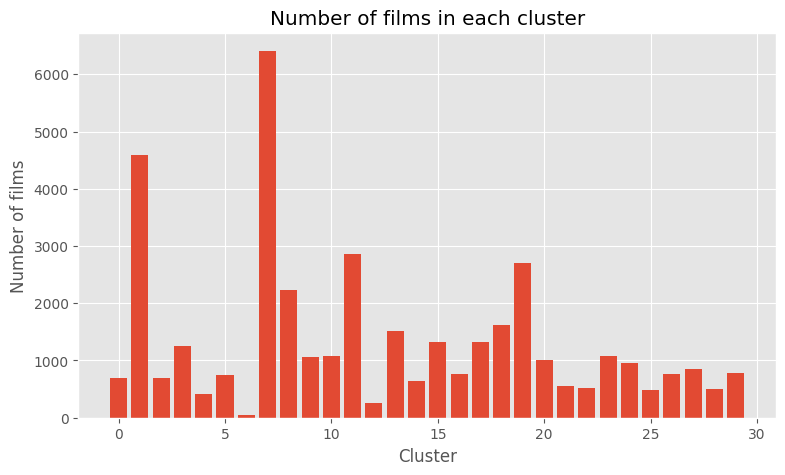

In [13]:
d = df['cluster'].value_counts()
d = d.sort_index()

plt.figure( figsize=(9, 5) )
plt.bar( d.index, d.values )
plt.title('Number of films in each cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of films')
plt.show()

We see that clusters have a pretty big difference in the number of films. For example, clusters 1 and 7 have a lot of films, but clusters 6 and 12 have much fewer films than the other clusters.

# Visualization of clusters 

For visualization, we need to reduce dimensionality to 2D, so we are going to use UMAP. It is a method that preserves the shapes of clusters better than PCA and is faster than t-SNE.

In [16]:
# applying umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=1.0, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)
centers_umap = umap_model.transform(centers)

In [17]:
# dictionary for color of clusters for visualization

colors = {
    0:  "#FF0000",  1: "#00FF00",  2: "#0000FF",  3: "#FFFF00",  4: "#FF00FF",
    5:  "#00FFFF",  6: "#FFA500",  7: "#800080",  8: "#008000",  9: "#000080",
    10: "#FFC0CB", 11: "#808000", 12: "#FF4500", 13: "#2E8B57", 14: "#4B0082",
    15: "#7FFF00", 16: "#DC143C", 17: "#20B2AA", 18: "#FFD700", 19: "#FF1493",
    20: "#00CED1", 21: "#B22222", 22: "#ADFF2F", 23: "#1E90FF", 24: "#DA70D6",
    25: "#40E0D0", 26: "#FF8C00", 27: "#9932CC", 28: "#00FA9A", 29: "#FF6347"
}

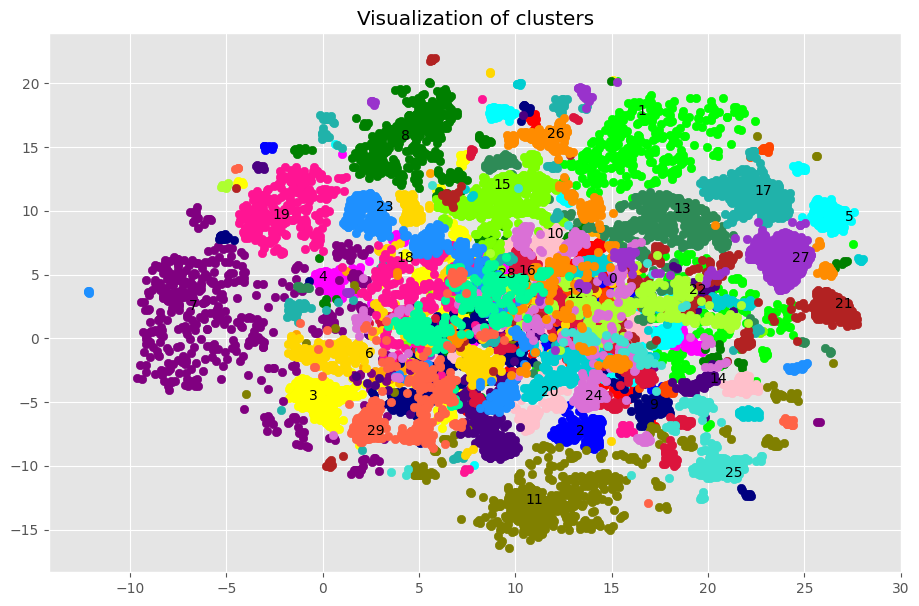

In [26]:
# visualization

plt.figure( figsize=(11, 7) ) 

num_clusters = np.arange(0, 30, 1)

for cluster in num_clusters:

    necessary_data = df[ df['cluster'] == cluster ]
    necessary_indexes = necessary_data.index.tolist()

    if len(necessary_indexes) >= 500:
        sample_indexes = np.random.choice( necessary_indexes, size=500, replace=False )  # get 500 random points
    else:
        sample_indexes = necessary_indexes

    necessary_X_umap = X_umap[ sample_indexes ]                    

    plt.scatter( necessary_X_umap[:, 0], necessary_X_umap[:, 1], color=colors[cluster] )
    plt.text( centers_umap[cluster, 0], centers_umap[cluster, 1], str(cluster) )  # for cluster signature

plt.title('Visualization of clusters')
plt.show()

We see that clusters are quite confused and overlapping, which is not surprising, but they still have a certain number of data points that form the basis of the cluster and separate it quite clearly from others.

# Saving model and necessary data for recomendation system

To create a recommendation system application, we need to save our model and data about the cluster labels of films.

In [27]:
# save kmeans model

joblib.dump( model, '../models/kmeans_model.joblib' )

['../models/kmeans_model.joblib']

In [29]:
# save cluster labels

df[['title','cluster']].to_csv('../data/cluster_labels.csv', index=False)